In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import autogluon.core as ag
from autogluon.vision import ObjectDetector

In [3]:
url = './tiny_motorbike/'
dataset_train = ObjectDetector.Dataset.from_voc(url, splits='trainval')
#print(dataset_train)

In [4]:
time_limit = 60*30  # at most 0.5 hour
detector = ObjectDetector()
hyperparameters = {'epochs': 5, 'batch_size': 8}
hyperparamter_tune_kwargs={'num_trials': 2}
detector.fit(dataset_train, time_limit=time_limit, hyperparameters=hyperparameters, hyperparamter_tune_kwargs=hyperparamter_tune_kwargs)

INFO:gluoncv.auto.tasks.object_detection:No GPU detected/allowed, using most conservative search space.
INFO:gluoncv.auto.tasks.object_detection:Randomly split train_data into train[149]/validation[21] splits.
INFO:gluoncv.auto.tasks.object_detection:Starting fit without HPO
INFO:SSDEstimator:modified configs(<old> != <new>): {
INFO:SSDEstimator:root.ssd.transfer    ssd_512_resnet50_v1_coco != ssd_512_mobilenet1.0_coco
INFO:SSDEstimator:root.ssd.data_shape  300 != 512
INFO:SSDEstimator:root.ssd.base_network vgg16_atrous != mobilenet1.0
INFO:SSDEstimator:root.gpus            (0, 1, 2, 3) != ()
INFO:SSDEstimator:root.dataset_root    ~/.mxnet/datasets/ != auto
INFO:SSDEstimator:root.dataset         voc_tiny != auto
INFO:SSDEstimator:root.valid.batch_size 16 != 8
INFO:SSDEstimator:root.num_workers     4 != 2
INFO:SSDEstimator:root.train.epochs    20 != 5
INFO:SSDEstimator:root.train.seed      233 != 607
INFO:SSDEstimator:root.train.early_stop_max_value 1.0 != inf
INFO:SSDEstimator:root.tra

In [5]:
dataset_test = ObjectDetector.Dataset.from_voc(url, splits='test')

test_map = detector.evaluate(dataset_test)

In [6]:
print(test_map)

(['motorbike', 'bus', 'bicycle', 'dog', 'boat', 'chair', 'pottedplant', 'person', 'cow', 'car', 'mAP'], [0.787789629735465, 0.0, nan, 0.09090909090909091, 0.0, nan, nan, nan, nan, nan, 0.21967468016113897])


In [7]:
print("mAP on test dataset: {}".format(test_map[1][-1]))

mAP on test dataset: 0.21967468016113897


In [8]:
image_path = dataset_test.iloc[0]['image']
result = detector.predict(image_path)
print(result)

   predict_class  predict_score  \
0         person       0.984763   
1      motorbike       0.450643   
2            car       0.422281   
3         person       0.321458   
4      motorbike       0.302548   
..           ...            ...   
95        person       0.045155   
96           car       0.045134   
97        person       0.045056   
98        person       0.044704   
99        person       0.044476   

                                         predict_rois  
0   {'xmin': 0.38947793841362, 'ymin': 0.291474342...  
1   {'xmin': 0.3032722473144531, 'ymin': 0.4574686...  
2   {'xmin': 0.001059547532349825, 'ymin': 0.64098...  
3   {'xmin': 0.9371292591094971, 'ymin': 0.0162389...  
4   {'xmin': 0.31802988052368164, 'ymin': 0.518892...  
..                                                ...  
95  {'xmin': 0.7588104009628296, 'ymin': 0.9772330...  
96  {'xmin': 0.0, 'ymin': 0.6459313631057739, 'xma...  
97  {'xmin': 0.7614843249320984, 'ymin': 0.9005128...  
98  {'xmin': 0.9619

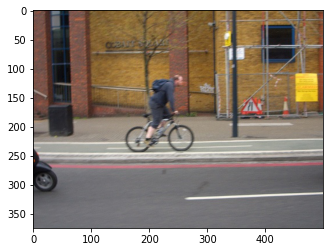

In [36]:
image0 = plt.imread(image_path)
plt.imshow(image0)

In [37]:
import cv2
image0 = cv2.imread(image_path)
good_result = result.query('predict_score >= 0.9')
good_result.head()

,predict_class,predict_score,predict_rois
0,person,0.984763,"{'xmin': 0.38947793841362, 'ymin': 0.291474342..."


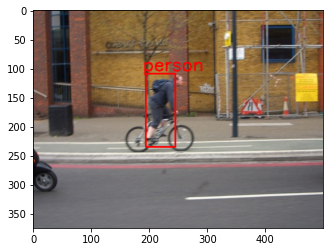

In [40]:
height, width = image0.shape[0:2]
for index, row in good_result.iterrows():
    rois, class_name = row['predict_rois'], row['predict_class']
    
    x1, y1 = int(rois['xmin']* width), int(rois['ymin']* height)
    x2, y2 = int(rois['xmax']* width), int(rois['ymax']* height)
    
    cv2.rectangle(image0, (x1, y1), (x2, y2), (0, 0, 255), thickness=2)
    cv2.putText(image0, class_name, (x1-5, y1-5), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 255), thickness=2)

image0_RGB = cv2.cvtColor(image0, cv2.COLOR_BGR2RGB)
plt.imshow(image0_RGB)

In [16]:
bulk_result = detector.predict(dataset_test)
print(bulk_result)

     predict_class  predict_score  \
0           person       0.992925   
1        motorbike       0.984032   
2        motorbike       0.248821   
3           person       0.213789   
4           person       0.205510   
...            ...            ...   
4708        person       0.056460   
4709        person       0.056405   
4710        person       0.056271   
4711        person       0.056085   
4712        person       0.056026   

                                           predict_rois  \
0     {'xmin': 0.39321503043174744, 'ymin': 0.314250...   
1     {'xmin': 0.32938188314437866, 'ymin': 0.445010...   
2     {'xmin': 0.284457266330719, 'ymin': 0.30877918...   
3     {'xmin': 0.738502025604248, 'ymin': 0.39611667...   
4     {'xmin': 0.45523062348365784, 'ymin': 0.295010...   
...                                                 ...   
4708  {'xmin': 0.5003928542137146, 'ymin': 0.2029617...   
4709  {'xmin': 0.4308430850505829, 'ymin': 0.4485945...   
4710  {'xmin': 0.5017036

In [17]:
savefile = 'detector.ag'
detector.save(savefile)
new_detector = ObjectDetector.load(savefile)

/home/jupyter/.local/lib/python3.7/site-packages/mxnet/gluon/block.py:1591: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


# Change fit parameters

In [3]:
url = './tiny_motorbike/'
dataset_train = ObjectDetector.Dataset.from_voc(url, splits='trainval')
detector = ObjectDetector()

In [4]:
# hyperparameters = {} # epochs, batch_size, lr, early_stop_patience, early_stop_min_delta, early_stop_baseline, early_stop_max_value
# holdout_frac = 0.1
# random_state = None
# nthreads_per_trial
# ngpus_per_trial
# hyperparamter_tune_kwargs={} # num_trials, search_strategy, max_reward, scheduler_options

## medium_quality_faster_train

In [ ]:
from autogluon.core import Categorical, Real

time_limit = 2*3600
hyperparameters = { 'transfer': Categorical('ssd_512_resnet50_v1_coco'), 
                   'lr': 0.01, 'batch_size': Categorical(8, 16),
                   'epochs': 30, 'early_stop_patience': 5}
hyperparamter_tune_kwargs={ 'num_trials': 16, 'search_strategy': 'random'}

detector.fit(dataset_train, time_limit=time_limit, 
             hyperparameters=hyperparameters, 
             hyperparamter_tune_kwargs=hyperparamter_tune_kwargs)

INFO:gluoncv.auto.tasks.object_detection:No GPU detected/allowed, using most conservative search space.
INFO:gluoncv.auto.tasks.object_detection:Randomly split train_data into train[163]/validation[7] splits.
INFO:gluoncv.auto.tasks.object_detection:Starting fit without HPO
INFO:SSDEstimator:modified configs(<old> != <new>): {
INFO:SSDEstimator:root.train.lr        0.001 != 0.01
INFO:SSDEstimator:root.train.early_stop_baseline 0.0 != -inf
INFO:SSDEstimator:root.train.seed      233 != 347
INFO:SSDEstimator:root.train.early_stop_max_value 1.0 != inf
INFO:SSDEstimator:root.train.early_stop_patience -1 != 5
INFO:SSDEstimator:root.train.batch_size 16 != 8
INFO:SSDEstimator:root.train.epochs    20 != 30
INFO:SSDEstimator:root.num_workers     4 != 2
INFO:SSDEstimator:root.dataset         voc_tiny != auto
INFO:SSDEstimator:root.ssd.base_network vgg16_atrous != resnet50_v1
INFO:SSDEstimator:root.ssd.data_shape  300 != 512
INFO:SSDEstimator:root.dataset_root    ~/.mxnet/datasets/ != auto
INFO:SS

In [ ]:
dataset_test = ObjectDetector.Dataset.from_voc(url, splits='test')

test_map = detector.evaluate(dataset_test)
print("mAP on test dataset: {}".format(test_map[1][-1]))

## medium_quality_faster_inference

In [ ]:
from autogluon.core import Categorical, Real

time_limit =4*3600
hyperparameters = {
                        'transfer': Categorical('center_net_resnet18_v1b_coco', 'yolo3_mobilenet1.0_coco'),
                        'lr': Categorical(0.01, 0.005, 0.001), 'batch_size': Categorical(32, 64, 128),
                        'epochs': Categorical(30, 50), 'early_stop_patience': 10 }
hyperparamter_tune_kwargs={ 'num_trials': 32, 'search_strategy': 'bayesopt'}

detector.fit(dataset_train, time_limit=time_limit, 
             hyperparameters=hyperparameters, 
             hyperparamter_tune_kwargs=hyperparamter_tune_kwargs)

In [ ]:
dataset_test = ObjectDetector.Dataset.from_voc(url, splits='test')

test_map = detector.evaluate(dataset_test)
print("mAP on test dataset: {}".format(test_map[1][-1]))